In [2]:
from numpy import loadtxt
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dropout, Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import numpy as np

2023-05-10 02:38:09.788050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 02:38:29.718361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-10 02:38:29.718754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-10 02:38:29.718770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [60]:
dataset = np.load('../data/dds_SNF_im1_orig_pref.npy', allow_pickle=True)

In [61]:
dataset.shape

(7791,)

In [62]:
bool_index = np.array([len(sub_arr) >= 1146 for sub_arr in dataset])
dataset_f = dataset[bool_index]

In [63]:
mat = np.vstack(dataset_f)

In [64]:
mat.shape

(7232, 1146)

In [65]:
dataset = mat

In [66]:
Y = dataset[:, -1]
print(Y[500])

0.0


In [67]:
X = dataset[:, 0:1145]
print(len(X[5001]))

1145


In [68]:
X.shape

(7232, 1145)

In [69]:
# X = dataset[:, 0:1225]
# Y = dataset[:, 1229]

print(X.shape)
sc = StandardScaler()
X = sc.fit_transform(X)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

_,dataInputDim = X.shape

dropoutRatio = 0.35
nUnits = 300
lol = 1
for train, test in kfold.split(X, Y):
    print("fold: " ,lol)
    lol+=1
    model = Sequential([
        Dense(input_dim=dataInputDim, units=nUnits, kernel_initializer='glorot_normal', activation='relu'),
        Dropout(dropoutRatio),
        Dense(input_dim=nUnits, units=nUnits, kernel_initializer='glorot_normal', activation='relu'),
        Dropout(dropoutRatio),
        Dense(input_dim=nUnits, units=1, kernel_initializer='glorot_normal', activation='sigmoid')
    ])
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 

    history = model.fit(X[train], Y[train], epochs=100, batch_size=100, shuffle=True, validation_data = (X[test], Y[test]))
    
    _, test_acc = model.evaluate(X[test], Y[test], verbose=0)
    print(f'Test accuracy: {test_acc}')

(7232, 1145)
fold:  1
Epoch 1/100


/home2/aswin/miniconda3/envs/pyg/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


49/49 [==============================] - 1s 15ms/step - loss: 0.6844 - accuracy: 0.6426 - val_loss: 0.5914 - val_accuracy: 0.6881
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5733 - accuracy: 0.7098 - val_loss: 0.5738 - val_accuracy: 0.7204
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.5257 - accuracy: 0.7511 - val_loss: 0.5682 - val_accuracy: 0.7308
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.4575 - accuracy: 0.7911 - val_loss: 0.5819 - val_accuracy: 0.7300
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.4192 - accuracy: 0.8168 - val_loss: 0.5960 - val_accuracy: 0.7263
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: 0.3756 - accuracy: 0.8378 - val_loss: 0.6152 - val_accuracy: 0.7316
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: 0.3384 - accuracy: 0.8538 - val_loss: 0.6549 - val_accuracy: 0.7325
Epoch 8/100
49/49 [=====

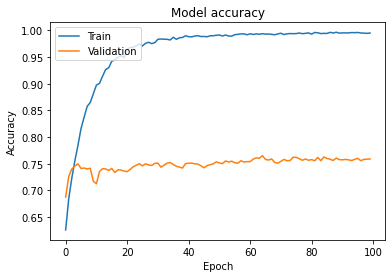

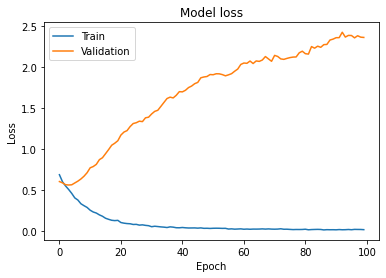

In [70]:
# Plot the training and validation accuracy and loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [71]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, confusion_matrix
import numpy as np

y_pred = model.predict(X[test])
y_pred_binary = np.round(y_pred)

y_true = Y[test]
confusion_mat = confusion_matrix(y_true, y_pred_binary)

TP = confusion_mat[1, 1]
FP = confusion_mat[0, 1]
TN = confusion_mat[0, 0]
FN = confusion_mat[1, 0]

accuracy = accuracy_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
mcc = matthews_corrcoef(y_true, y_pred_binary)
auc_roc = roc_auc_score(y_true, y_pred)
precision, recall_pr, _ = precision_recall_curve(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred)

print(f'Test accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Recall: {float(recall):.2f}')
print(f'MCC: {mcc:.2f}')
print(f'AUC-ROC: {auc_roc:.2f}')
print(f'AUC-PR: {auc_pr:.2f}')
print(f'True positives: {TP}')
print(f'False positives: {FP}')
print(f'True negatives: {TN}')
print(f'False negatives: {FN}')

76/76 [==============================] - 0s 2ms/step
Test accuracy: 0.76
F1-score: 0.61
Recall: 0.57
MCC: 0.44
AUC-ROC: 0.76
AUC-PR: 0.66
True positives: 461
False positives: 236
True negatives: 1368
False negatives: 345


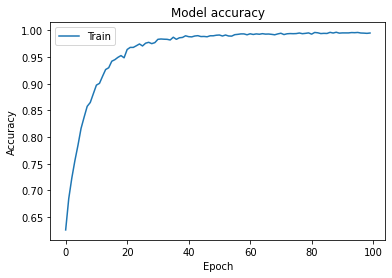

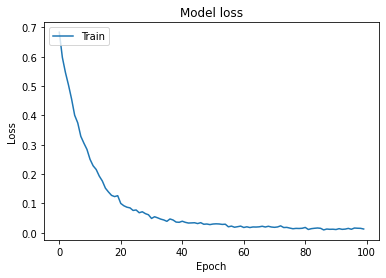

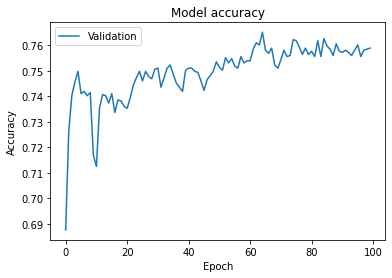

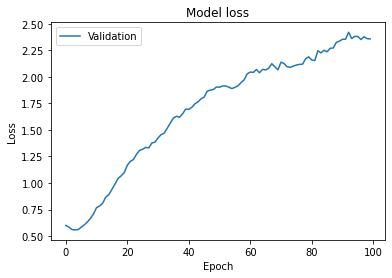

In [72]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([ 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([ 'Validation'], loc='upper left')
plt.show()